# Задача 10. Graph Convolutional Network

## Импортируем нужные библиотеки

In [2]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import add_self_loops

## Dataset

В качестве датасета был выбран `CiteSeer`

- Узлы — научные статьи.
- Рёбра — цитирования между статьями.
- Признаки узлов — бинарные вектора из текста статей. (т.е в колонке соответствующего слова стоит 0 или 1 в зависимости от того, встречается это слово в статье или нет)
- Метки классов — тематические категории статей (например, Artificial Intelligence, Databases).

In [ ]:
dataset = Planetoid(root='dataset', name='CiteSeer')
data = dataset[0]

In [4]:
data.num_nodes, data.num_edges, dataset.num_classes

(3327, 9104, 6)

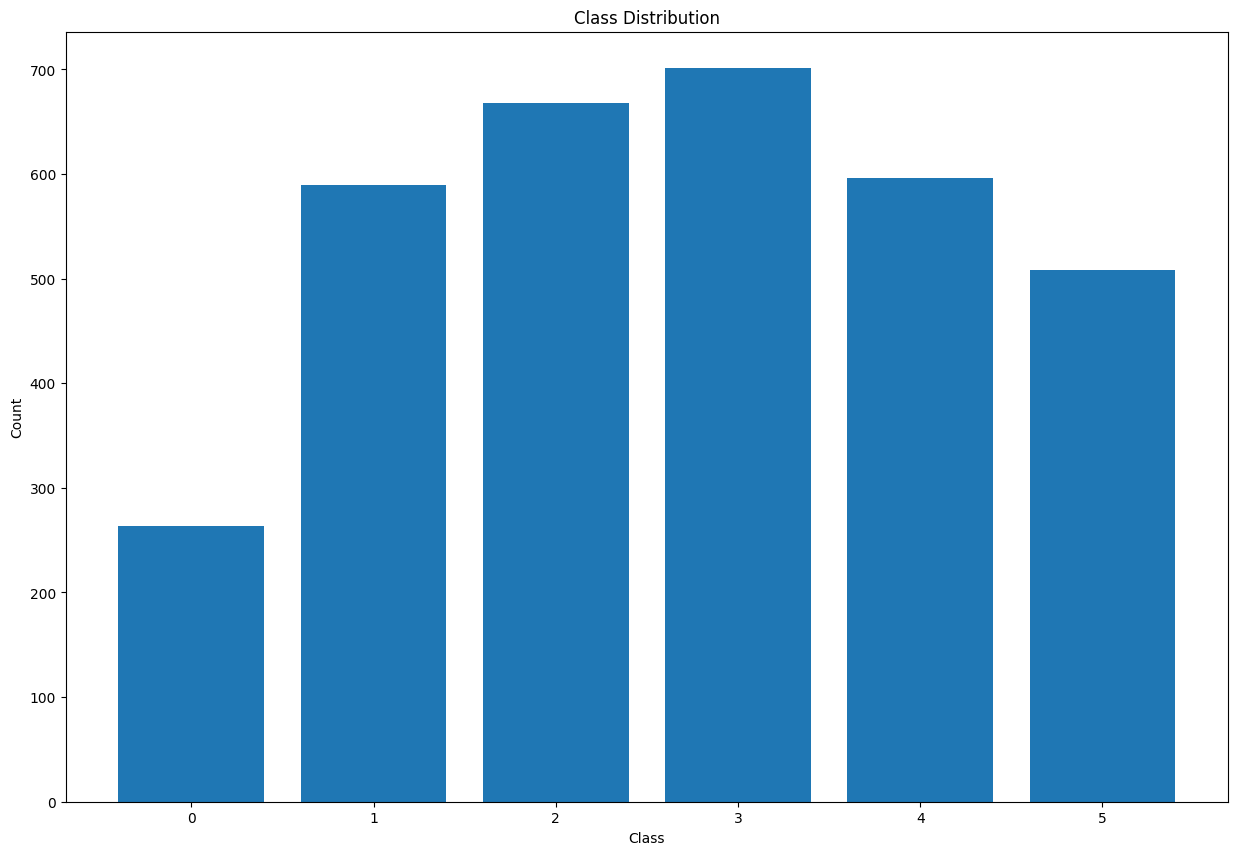

In [5]:
count = np.bincount(data.y.cpu().numpy())
plt.figure(figsize=(15, 10))
plt.bar(np.arange(len(count)), count)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.show()

Можно заметить, что распределение классов не очень сбалансированно, это важно будет помнить при вычислении метрик

## GCN-модель

In [6]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(0.2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [7]:
model = GCN(dataset.num_node_features, 16, dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [8]:
def train():
    model.train()
    optimizer.zero_grad()
    result = model(data.x, data.edge_index)
    loss = F.nll_loss(result[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def test():
    model.eval()
    out = model(data.x, data.edge_index)
    preds = out.argmax(dim=1)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = preds[mask].eq(data.y[mask]).sum().item()
        accs.append(correct / mask.sum().item())
    return accs

In [12]:
lr_list = [0.1, 0.01, 0.001, 0.0001]
epochs = 200

In [13]:
for lr in lr_list:
    print(f"\nTraining with lr={lr:.4f}")

    model = GCN(dataset.num_node_features, 16, dataset.num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)

    for epoch in range(epochs):
        train()

    acc = test()
    print(acc)


Training with lr=0.1000
[1.0, 0.62, 0.612]

Training with lr=0.0100
[1.0, 0.688, 0.683]

Training with lr=0.0010
[1.0, 0.678, 0.659]

Training with lr=0.0001
[0.8333333333333334, 0.564, 0.55]


Лучший результат вышел с `lr=0.01`

## Самостоятельный GCNConv и обучение

In [40]:
class MyGCNLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.linear = torch.nn.Linear(in_channels, out_channels)
        self.bias = torch.nn.Parameter(torch.Tensor(out_channels))
        self.linear.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index):
        num_nodes = x.size(0)

        edge_index, _ = add_self_loops(edge_index, num_nodes=num_nodes)

        row, col = edge_index

        deg = torch.bincount(row, minlength=num_nodes).float()
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0

        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        adj = torch.sparse_coo_tensor(
            edge_index,
            norm,
            (num_nodes, num_nodes)
        )

        x = self.linear(x)
        x = torch.sparse.mm(adj, x)
        x += self.bias
        return x

In [41]:
class MyGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = MyGCNLayer(in_channels, hidden_channels)
        self.conv2 = MyGCNLayer(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [42]:
model = MyGCN(dataset.num_node_features, 16, dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [43]:
for epoch in range(epochs):
        train()

In [44]:
test_acc = test()

In [45]:
test_acc

[1.0, 0.678, 0.68]

## Результаты

Получились результаты, схожие с результатами модели `GCN`, построенной с слоями `GCNConv` из `PyG`